In [1]:
# Import libraries for loading data, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import join

# Load Review Data

Load and filter data for analysis/visualization

In [2]:
# This gets you to your code directory
path = Path.cwd()
# This gets you to your project directory
ROOT_DIR = path.parent.absolute()
# Root for data directory
r_fp = join(ROOT_DIR, 'data', 'processed')

In [3]:
# Read review data
open_df = pd.read_csv(join(r_fp, 'articles_reviewed.csv'),
                      encoding='latin1')
# Drop articles with dropped == 1
open_df = open_df[open_df['dropped'] != 1]

In [4]:
# Read journal data and get 2022 JIF
journals = pd.read_csv(join(r_fp, 'journals_to_search.csv'))

# Make Journal name column in journals all upper case
# Get dict of this to 2022 JIF column
jif_dict = dict(zip(journals['Journal name'].str.upper(),
                    journals['2022 JIF']))

# After doing grouping and pivots for summary stats and plotting,
# we will use this dict to get JIF linked 

## Use data and code included to get final categories

In [5]:
# For the partially closed classifications, there are some
# papers worth identifying as closer to open than the others

# For data, we will relabel the following as 
# "Mostly open, additional barriers to reproduction"
# All 
# Raw; Results; Source Data 
# Raw; Results
# These are categories where there are obstacles to immediate access
# (need permission to download from repo, need to track down raw from
# URLs) but there could be -- with all the code -- enough. It's ambiguous
# but worth coding differently to acknowledge they are not open, but also
# not the same as studies with substantial barriers to the ethos
# of openness
# The other categories are
# Open, unique and persistent repository
# Mostly closed, substantial barriers to reproduction
# Closed
# These are defined in terms of Open, Partially Closed (but not the other 
# category), and Closed, respectively 

# For the purposes of transforming and processing data, these column
# names present a challenge, so we will also use a col_name_dict
# Use open, mostly_open, mostly_closed, closed as keys
col_name_dict = {'open': 'Open',
                 'mostly_open': 'Mostly open',
                 'mostly_closed': 'Mostly closed',
                 'closed': 'Closed'}


open_df.loc[open_df['data_open'] == 'Open',
            'data_cat'] = 'open'

open_df.loc[(open_df['data_open'] == 'Partially Closed'),
            'data_cat'] = 'mostly_closed'
data_cats = ['All', 'Raw; Results; Source Data', 'Raw; Results']
open_df.loc[(open_df['data_open'] == 'Partially Closed') &
            (open_df['data_included'].isin(data_cats)),
            'data_cat'] = 'mostly_open'
open_df.loc[(open_df['data_open'] == 'Closed'),
            'data_cat'] = 'closed'

# Similarly, for code, 
# All
# Download; Process; Analysis; Figures
# Processing; Generate Results
# Processing; Results
# Since these have issues like GitHub instead of 
# persistent & unique identifier, or being potentially enough
# to reproduce (but depends on data & how much the code actually gets you)
open_df.loc[open_df['code_open'] == 'Open',
            'code_cat'] = 'open'

open_df.loc[(open_df['code_open'] == 'Partially Closed'),
            'code_cat'] = 'mostly_closed'
code_cats = ['All', 'Download; Process; Analysis; Figures',
             'Processing; Generate Results', 'Processing; Results']
open_df.loc[(open_df['code_open'] == 'Partially Closed') &
            (open_df['code_included'].isin(code_cats)),
            'code_cat'] = 'mostly_open'
open_df.loc[(open_df['code_open'] == 'Closed'),
            'code_cat'] = 'closed'

# Summarize Review

## Get summary statistics overall and by journal

In [6]:
# Overall data and code
print(open_df['data_cat'].value_counts())
print()
print(open_df['code_cat'].value_counts())
print()

print(open_df['data_cat'].value_counts()/len(open_df))
print()
print(open_df['code_cat'].value_counts()/len(open_df))
print()


# Check that there are no missing records
check = (open_df['data_cat'].value_counts().sum() ==
         open_df['code_cat'].value_counts().sum())

if check:
    print('Continue :)')
else:
    print('STOP!!!')
    

data_cat
closed           165
mostly_closed     68
open              15
mostly_open       10
Name: count, dtype: int64

code_cat
closed           190
mostly_closed     47
open              13
mostly_open        8
Name: count, dtype: int64

data_cat
closed           0.639535
mostly_closed    0.263566
open             0.058140
mostly_open      0.038760
Name: count, dtype: float64

code_cat
closed           0.736434
mostly_closed    0.182171
open             0.050388
mostly_open      0.031008
Name: count, dtype: float64

Continue :)


In [7]:
print(open_df.groupby(['data_cat', 'code_cat']).size())

data_cat       code_cat     
closed         closed           152
               mostly_closed     10
               mostly_open        2
               open               1
mostly_closed  closed            34
               mostly_closed     28
               mostly_open        4
               open               2
mostly_open    closed             2
               mostly_closed      6
               mostly_open        2
open           closed             2
               mostly_closed      3
               open              10
dtype: int64


In [8]:
print(open_df.groupby(['data_cat', 'code_cat']).size()/len(open_df))

data_cat       code_cat     
closed         closed           0.589147
               mostly_closed    0.038760
               mostly_open      0.007752
               open             0.003876
mostly_closed  closed           0.131783
               mostly_closed    0.108527
               mostly_open      0.015504
               open             0.007752
mostly_open    closed           0.007752
               mostly_closed    0.023256
               mostly_open      0.007752
open           closed           0.007752
               mostly_closed    0.011628
               open             0.038760
dtype: float64


In [9]:
# Get a dataframe of data openness by journal
# Can use any column as the values argument since
# the data is one record per row
data_byj = open_df.pivot_table(columns=['data_cat'], index=['journal'], 
                               values=['authors'], aggfunc='count').fillna(0)

# Get a dataframe of code openness by journal
code_byj = open_df.pivot_table(columns=['code_cat'], index=['journal'],
                               values=['authors'], aggfunc='count').fillna(0)

# Rest indices
data_byj = data_byj.reset_index()
code_byj = code_byj.reset_index()
# Map in the 2022 JIF column
data_byj['jif'] = data_byj['journal'].map(jif_dict)
code_byj['jif'] = code_byj['journal'].map(jif_dict)

# Get number of articles reviewed per journal
jsize_df = open_df['journal'].value_counts().reset_index()
jcount_dict = dict(zip(jsize_df['journal'], jsize_df['count']))
# Map these numbers into data_byj and code_byj
data_byj['n_rev'] = data_byj['journal'].map(jcount_dict)
code_byj['n_rev'] = code_byj['journal'].map(jcount_dict)

In [10]:
# Get proportions for each category based on n_rev
# and print wiht journal in the index
j_prop_d = ((data_byj.iloc[:, 1:5].T)/data_byj.iloc[:,-1]).T
j_prop_d_df = j_prop_d.set_index(data_byj['journal']).reset_index()
# Map in the jif to the prop df
j_prop_d_df['jif'] = j_prop_d_df['journal'].map(jif_dict)
print('Proportions\n')
# view the proportions
# look at printed table from next cell to verify
j_prop_d.set_index(data_byj['journal'])

Proportions



authors                            \
data_cat                               closed mostly_closed mostly_open   
journal                                                                   
COMMUNICATIONS EARTH & ENVIRONMENT   0.448276      0.448276    0.068966   
EARTHS FUTURE                        0.703704      0.185185    0.000000   
ENVIRONMENTAL RESEARCH               1.000000      0.000000    0.000000   
ENVIRONMENTAL SCIENCE & TECHNOLOGY   0.740741      0.259259    0.000000   
GLOBAL CHANGE BIOLOGY                0.464286      0.428571    0.000000   
JOURNAL OF ENVIRONMENTAL MANAGEMENT  1.000000      0.000000    0.000000   
LANCET PLANETARY HEALTH              0.736842      0.105263    0.052632   
NATURE CLIMATE CHANGE                0.241379      0.482759    0.103448   
ONE EARTH                            0.066667      0.666667    0.200000   
REMOTE SENSING OF ENVIRONMENT        0.800000      0.160000    0.040000   
WATER RESEARCH                       0.923077      0.076923    0.000000   

                                               
data_cat                                 open  
journal                                        
COMMUNICATIONS EARTH & ENVIRONMENT   0.034483  
EARTHS FUTURE                        0.111111  
ENVIRONMENTAL RESEARCH               0.000000  
ENVIRONMENTAL SCIENCE & TECHNOLOGY   0.000000  
GLOBAL CHANGE BIOLOGY                0.107143  
JOURNAL OF ENVIRONMENTAL MANAGEMENT  0.000000  
LANCET PLANETARY HEALTH              0.105263  
NATURE CLIMATE CHANGE                0.172414  
ONE EARTH                            0.066667  
REMOTE SENSING OF ENVIRONMENT        0.000000  
WATER RESEARCH                       0.000000

In [11]:
# look at counts table for data to verify
data_byj

journal authors                \
data_cat                                       closed mostly_closed   
0          COMMUNICATIONS EARTH & ENVIRONMENT    13.0          13.0   
1                               EARTHS FUTURE    19.0           5.0   
2                      ENVIRONMENTAL RESEARCH    20.0           0.0   
3          ENVIRONMENTAL SCIENCE & TECHNOLOGY    20.0           7.0   
4                       GLOBAL CHANGE BIOLOGY    13.0          12.0   
5         JOURNAL OF ENVIRONMENTAL MANAGEMENT    26.0           0.0   
6                     LANCET PLANETARY HEALTH    14.0           2.0   
7                       NATURE CLIMATE CHANGE     7.0          14.0   
8                                   ONE EARTH     1.0          10.0   
9               REMOTE SENSING OF ENVIRONMENT    20.0           4.0   
10                             WATER RESEARCH    12.0           1.0   

                            jif n_rev  
data_cat mostly_open open              
0                2.0  1.0   7.9    29  
1                0.0  3.0   8.2    27  
2                0.0  0.0   8.3    20  
3                0.0  0.0  11.4    27  
4                0.0  3.0  11.6    28  
5                0.0  0.0   8.7    26  
6                1.0  2.0  25.7    19  
7                3.0  5.0  30.7    29  
8                3.0  1.0  16.2    15  
9                1.0  0.0  13.5    25  
10               0.0  0.0  12.8    13

In [12]:
# Repeat for code
j_prop_c = ((code_byj.iloc[:, 1:5].T)/code_byj.iloc[:,-1]).T
j_prop_c_df = j_prop_c.set_index(code_byj['journal']).reset_index()
# Map in the jif to the prop df
j_prop_c_df['jif'] = j_prop_c_df['journal'].map(jif_dict)
print('Proportions\n')
# view the proportions
# look at printed table from next cell to verify
j_prop_c.set_index(code_byj['journal'])

Proportions



authors                            \
code_cat                               closed mostly_closed mostly_open   
journal                                                                   
COMMUNICATIONS EARTH & ENVIRONMENT   0.344828      0.482759    0.103448   
EARTHS FUTURE                        0.777778      0.148148    0.000000   
ENVIRONMENTAL RESEARCH               1.000000      0.000000    0.000000   
ENVIRONMENTAL SCIENCE & TECHNOLOGY   0.925926      0.074074    0.000000   
GLOBAL CHANGE BIOLOGY                0.821429      0.071429    0.035714   
JOURNAL OF ENVIRONMENTAL MANAGEMENT  1.000000      0.000000    0.000000   
LANCET PLANETARY HEALTH              0.894737      0.000000    0.000000   
NATURE CLIMATE CHANGE                0.206897      0.586207    0.068966   
ONE EARTH                            0.600000      0.200000    0.133333   
REMOTE SENSING OF ENVIRONMENT        0.840000      0.160000    0.000000   
WATER RESEARCH                       0.923077      0.076923    0.000000   

                                               
code_cat                                 open  
journal                                        
COMMUNICATIONS EARTH & ENVIRONMENT   0.068966  
EARTHS FUTURE                        0.074074  
ENVIRONMENTAL RESEARCH               0.000000  
ENVIRONMENTAL SCIENCE & TECHNOLOGY   0.000000  
GLOBAL CHANGE BIOLOGY                0.071429  
JOURNAL OF ENVIRONMENTAL MANAGEMENT  0.000000  
LANCET PLANETARY HEALTH              0.105263  
NATURE CLIMATE CHANGE                0.137931  
ONE EARTH                            0.066667  
REMOTE SENSING OF ENVIRONMENT        0.000000  
WATER RESEARCH                       0.000000

In [13]:
code_byj

journal authors                \
code_cat                                       closed mostly_closed   
0          COMMUNICATIONS EARTH & ENVIRONMENT    10.0          14.0   
1                               EARTHS FUTURE    21.0           4.0   
2                      ENVIRONMENTAL RESEARCH    20.0           0.0   
3          ENVIRONMENTAL SCIENCE & TECHNOLOGY    25.0           2.0   
4                       GLOBAL CHANGE BIOLOGY    23.0           2.0   
5         JOURNAL OF ENVIRONMENTAL MANAGEMENT    26.0           0.0   
6                     LANCET PLANETARY HEALTH    17.0           0.0   
7                       NATURE CLIMATE CHANGE     6.0          17.0   
8                                   ONE EARTH     9.0           3.0   
9               REMOTE SENSING OF ENVIRONMENT    21.0           4.0   
10                             WATER RESEARCH    12.0           1.0   

                            jif n_rev  
code_cat mostly_open open              
0                3.0  2.0   7.9    29  
1                0.0  2.0   8.2    27  
2                0.0  0.0   8.3    20  
3                0.0  0.0  11.4    27  
4                1.0  2.0  11.6    28  
5                0.0  0.0   8.7    26  
6                0.0  2.0  25.7    19  
7                2.0  4.0  30.7    29  
8                2.0  1.0  16.2    15  
9                0.0  0.0  13.5    25  
10               0.0  0.0  12.8    13

## Plot the journal-level results

In [14]:
# Keep cols
# This is the order of the cols in j_prop_c_df 
# and j_prop_d_df
keep_cols = ['closed',
             'mostly_closed',
             'mostly_open',
             'open']

# Mapping Journal Acronyms to Abbreviations
name_dict = {
    'NCC': "Nat Clim\nChange",
    'LPH': "Lancet\nPlan Hlth",
    'EF': "Earth's\nFuture",
    'GCB': "Glb Chg\nBio",
    'CE&E': "Comm\nE&E",
    'OE': "One\nEarth",
    'RSOE': "Rem Sens\nEnv",
    'WR': "Water\nRes",
    'ES&T': "Env Sci\n&Tech",
    'JOEM': "Jrnl Env\nMgmt",
    'ER': "Env\nRes"
}

# Mapping Journal Acronyms to Standards
# Need to copy/paste all these
# into supplementary info where we
# summarize the standards
# The main thing to capture is the very minimal notion
# of whether anything is said at all about data &
# code availability. It is hard to navigate the subjective
# notion of "strength" of requirements. We objectively track
# the strength with the core aspect of our review.
# So here, we just look at who even says anything. 
# Generally, the language is more like "encourage"
# than "mandate" but even within a particular 
# standard it varies in strength (i.e. encourage & require
# are often seen together, so an objective mapping is
# not easy to do)

# References for this
# NCC & CE&E: https://www.nature.com/nature-portfolio/
# editorial-policies/reporting-standards
# Data & Code
# (Spring Nature requires, journals link to)

# Earth's Future: https://www.agu.org/publish-with-agu/publish/
# author-resources/data-and-software-for-authors
# Data & Code
# (AGU requires, journal links to)

# Lancet Planetary Health
# https://www.thelancet.com/pb-assets/Lancet/
# authors/tlplanet-info-for-authors.pdf
# Data 

# Global Change Biology
# https://onlinelibrary.wiley.com/page/journal/13652486/homepage/
# forauthors.html
# Data and code

# One Earth
# https://www.cell.com/one-earth/author
# Data and code

# Remote sensing of the environment
# https://www.sciencedirect.com/journal/remote-sensing-of-environment/
# publish/guide-for-authors
# Data (very light)

# Water research
# https://www.sciencedirect.com/journal/
# water-research/publish/guide-for-authors
# Data and code (uses the word "requires" and offers
# many resources to abide)

# Env. Sci. and Technology
# https://publish.acs.org/publish/author_guidelines?coden=esthag
# Data and code

# Journal of Environmental Management
# https://www.sciencedirect.com/journal/journal-of-environmental-management/
# publish/guide-for-authors
# Data

# Journal of Environmental Management
# https://www.sciencedirect.com/journal/environmental-research/
# publish/guide-for-authors
# Data

# Data
data_name_dict = {
    'NCC': "Yes",
    'LPH': "Yes",
    'EF': "Yes",
    'GCB': "Yes",
    'CE&E': "Yes",
    'OE': "Yes",
    'RSOE': "Yes",
    'WR': "Yes",
    'ES&T': "Yes",
    'JOEM': "Yes",
    'ER': "Yes"
}

data_name_dict = {
    'NCC': "Yes",
    'LPH': "No",
    'EF': "Yes",
    'GCB': "Yes",
    'CE&E': "Yes",
    'OE': "Yes",
    'RSOE': "Yes",
    'WR': "Yes",
    'ES&T': "Yes",
    'JOEM': "No",
    'ER': "No"
}

# Code

# We will sort on these to get order of journals on x-axis
sort_col1 = 'open'
sort_col2 = 'mostly_open'
sort_col3 = 'jif'
sort_col = 'open_enough'

# Prepare code
# We want the x-axis to be an abbrevation/acronym for the journal
# and the 2022 JIF in parantheses
# We sort by most open from left to right
j_prop_c_df.columns = ['journal'] + keep_cols + ['jif']
j_prop_c_df[sort_col] = j_prop_c_df[sort_col1] + j_prop_c_df[sort_col2]
code_plot = j_prop_c_df.sort_values([sort_col, sort_col3],
                                     ascending=False)
code_plot['j_acr'] = code_plot['journal'].str.split(' ').apply(lambda x: ''.join([i[0][0] for i in x]))
code_plot['acr_jif'] = code_plot['j_acr'].map(name_dict) + '\n(' + code_plot['jif'].astype(str) + ')'
# We only need to keep the openness columns for plotting
code_df = code_plot.set_index('acr_jif')[keep_cols]

# Repeat for data - also sorted by code openness
j_prop_d_df.columns = ['journal'] + keep_cols + ['jif']
j_prop_d_df[sort_col] = j_prop_d_df[sort_col1] + j_prop_d_df[sort_col2]
data_plot = j_prop_d_df.sort_values([sort_col, sort_col3],
                                     ascending=False)
data_plot['j_acr'] = data_plot['journal'].str.split(' ').apply(lambda x: ''.join([i[0][0] for i in x]))
data_plot['acr_jif'] = data_plot['j_acr'].map(name_dict) + '\n(' + data_plot['jif'].astype(str) + ')'
data_df = data_plot.set_index('acr_jif')[keep_cols]
# We reindex on the code_df dataframe index to have
# the journals lined up
data_df = data_df.reindex(code_df.index)

# Get rounded percentages
data_df = round(data_df*100, 2)
code_df = round(code_df*100, 2)

In [15]:
# look at the data_df
data_df

,closed,mostly_closed,mostly_open,open
acr_jif,,,,
Nat Clim\nChange\n(30.7),24.14,48.28,10.34,17.24
One\nEarth\n(16.2),6.67,66.67,20.00,6.67
Comm\nE&E\n(7.9),44.83,44.83,6.90,3.45
Glb Chg\nBio\n(11.6),46.43,42.86,0.00,10.71
Lancet\nPlan Hlth\n(25.7),73.68,10.53,5.26,10.53
Earth's\nFuture\n(8.2),70.37,18.52,0.00,11.11
Rem Sens\nEnv\n(13.5),80.00,16.00,4.00,0.00
Water\nRes\n(12.8),92.31,7.69,0.00,0.00
Env Sci\n&Tech\n(11.4),74.07,25.93,0.00,0.00


In [16]:
# check data_df to our first df of proportions
# to confirm correctness
j_prop_d_df

,journal,closed,mostly_closed,mostly_open,open,jif,open_enough
0,COMMUNICATIONS EARTH & ENVIRONMENT,0.448276,0.448276,0.068966,0.034483,7.9,0.103448
1,EARTHS FUTURE,0.703704,0.185185,0.000000,0.111111,8.2,0.111111
2,ENVIRONMENTAL RESEARCH,1.000000,0.000000,0.000000,0.000000,8.3,0.000000
3,ENVIRONMENTAL SCIENCE & TECHNOLOGY,0.740741,0.259259,0.000000,0.000000,11.4,0.000000
4,GLOBAL CHANGE BIOLOGY,0.464286,0.428571,0.000000,0.107143,11.6,0.107143
5,JOURNAL OF ENVIRONMENTAL MANAGEMENT,1.000000,0.000000,0.000000,0.000000,8.7,0.000000
6,LANCET PLANETARY HEALTH,0.736842,0.105263,0.052632,0.105263,25.7,0.157895
7,NATURE CLIMATE CHANGE,0.241379,0.482759,0.103448,0.172414,30.7,0.275862
8,ONE EARTH,0.066667,0.666667,0.200000,0.066667,16.2,0.266667
9,REMOTE SENSING OF ENVIRONMENT,0.800000,0.160000,0.040000,0.000000,13.5,0.040000


In [17]:
# do the same for code
code_df

,closed,mostly_closed,mostly_open,open
acr_jif,,,,
Nat Clim\nChange\n(30.7),20.69,58.62,6.90,13.79
One\nEarth\n(16.2),60.00,20.00,13.33,6.67
Comm\nE&E\n(7.9),34.48,48.28,10.34,6.90
Glb Chg\nBio\n(11.6),82.14,7.14,3.57,7.14
Lancet\nPlan Hlth\n(25.7),89.47,0.00,0.00,10.53
Earth's\nFuture\n(8.2),77.78,14.81,0.00,7.41
Rem Sens\nEnv\n(13.5),84.00,16.00,0.00,0.00
Water\nRes\n(12.8),92.31,7.69,0.00,0.00
Env Sci\n&Tech\n(11.4),92.59,7.41,0.00,0.00


In [18]:
j_prop_c_df

,journal,closed,mostly_closed,mostly_open,open,jif,open_enough
0,COMMUNICATIONS EARTH & ENVIRONMENT,0.344828,0.482759,0.103448,0.068966,7.9,0.172414
1,EARTHS FUTURE,0.777778,0.148148,0.000000,0.074074,8.2,0.074074
2,ENVIRONMENTAL RESEARCH,1.000000,0.000000,0.000000,0.000000,8.3,0.000000
3,ENVIRONMENTAL SCIENCE & TECHNOLOGY,0.925926,0.074074,0.000000,0.000000,11.4,0.000000
4,GLOBAL CHANGE BIOLOGY,0.821429,0.071429,0.035714,0.071429,11.6,0.107143
5,JOURNAL OF ENVIRONMENTAL MANAGEMENT,1.000000,0.000000,0.000000,0.000000,8.7,0.000000
6,LANCET PLANETARY HEALTH,0.894737,0.000000,0.000000,0.105263,25.7,0.105263
7,NATURE CLIMATE CHANGE,0.206897,0.586207,0.068966,0.137931,30.7,0.206897
8,ONE EARTH,0.600000,0.200000,0.133333,0.066667,16.2,0.200000
9,REMOTE SENSING OF ENVIRONMENT,0.840000,0.160000,0.000000,0.000000,13.5,0.000000


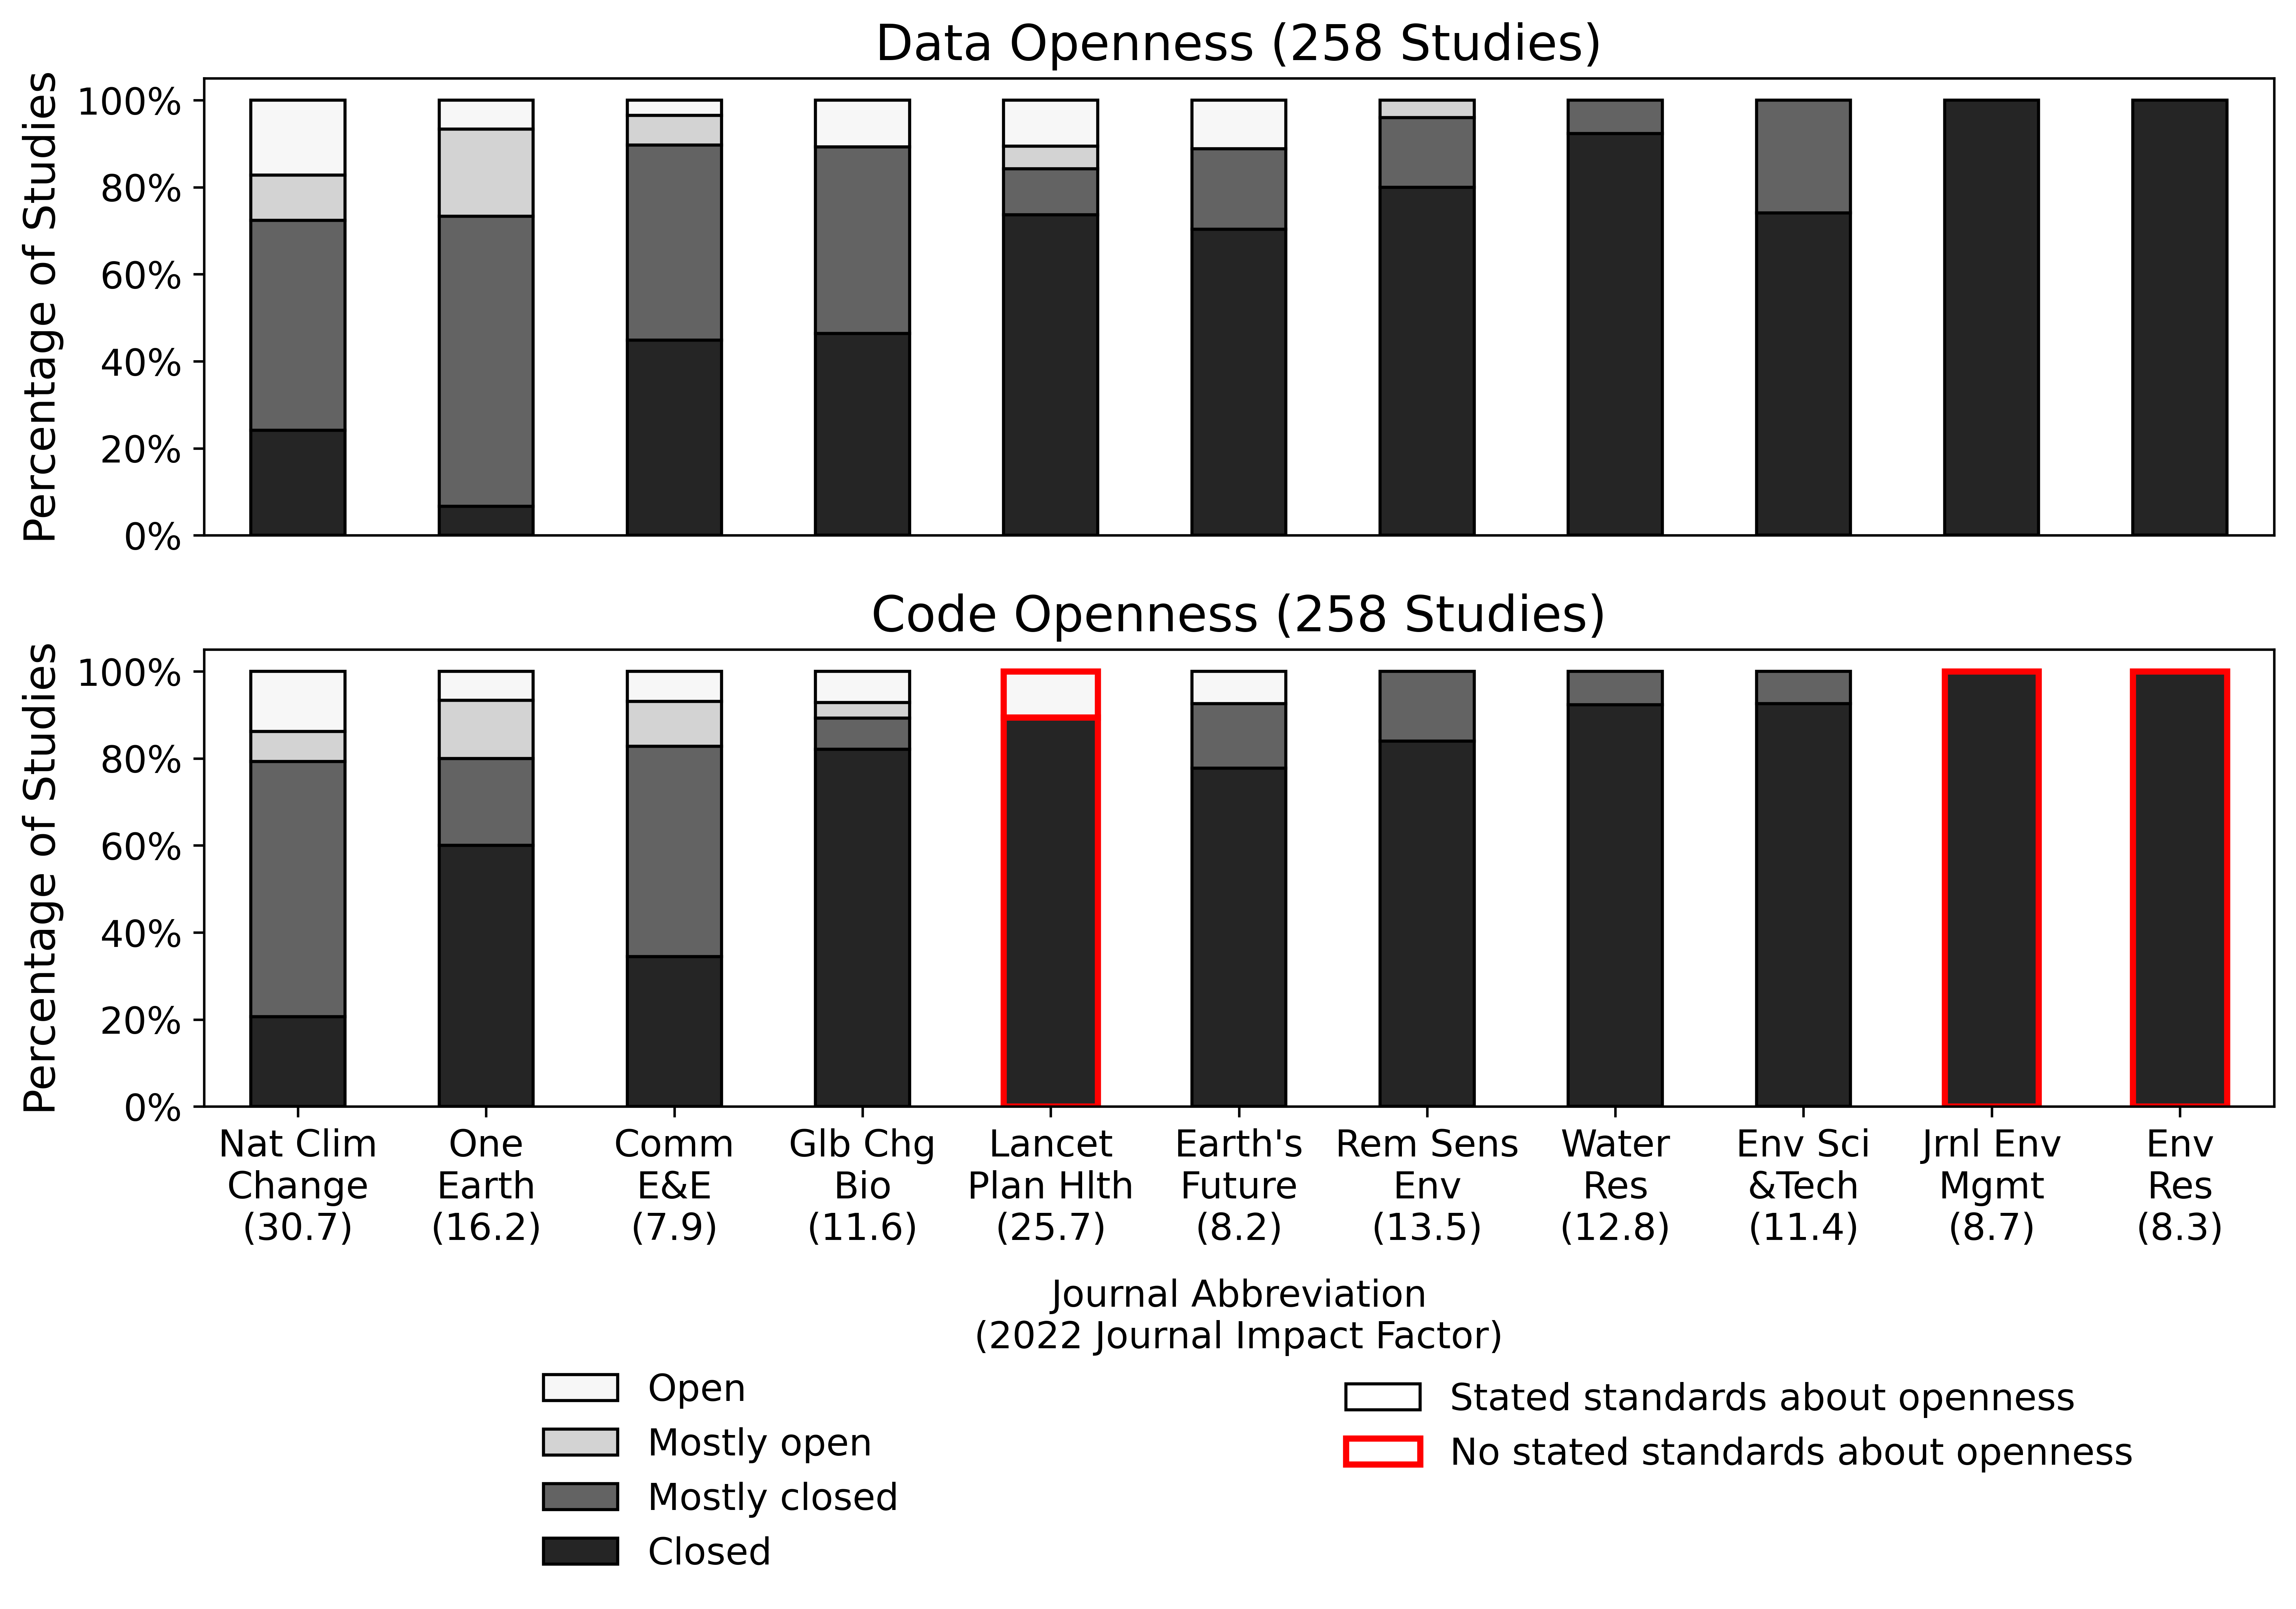

In [19]:
# Use the col_name_dict for figure purposes
data_df = data_df.rename(columns=col_name_dict)
code_df = code_df.rename(columns=col_name_dict)

# Plot on a 1 by 2 axis
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, 
                       sharex=True, dpi=600)

# Need the dataframes to have a column that indicates
# have stated standards vs. don't have stated standards
# We would subset these dataframes and plot them
# with different color edges around the bins
# Maybe red vs. black (red for do not have)

data_df.plot(ax=ax[0], kind='bar', stacked=True,
             color=['#252525', '#636363', '#d3d3d3', '#f7f7f7'],
             edgecolor='black',
             legend=False)

code_df.plot(ax=ax[1], kind='bar', stacked=True, 
             lw=[1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2],
             color=['#252525', '#636363', '#d3d3d3', '#f7f7f7'],
             edgecolor=['black', 'black', 'black', 'black',
                        'red', 'black', 'black', 'black',
                        'black', 'red', 'red'],
             legend=False)


ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Percentage of Studies', size=14)
ax[0].tick_params(axis='x', which='both',
                  bottom=False)

ax[0].set_title('Data Openness (258 Studies)', size=16)
ax[1].set_title('Code Openness (258 Studies)', size=16)

ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

handles, labels = ax[1].get_legend_handles_labels()

ax[1].legend(reversed(handles),
             reversed(labels),
             loc='center',
             bbox_to_anchor=(0.25, -0.8),
             fancybox=False,
             shadow=False,
             frameon=False,
             fontsize='large',
             ncol=1)

ax[1].set_xlabel('Journal Abbreviation\n(2022 Journal Impact Factor)',
                 size=12,
                 labelpad=10)
ax[1].set_xticks(ax[1].get_xticks(),
                 ax[1].get_xticklabels(),
                 rotation=0,
                 ha='center')

plt.subplots_adjust(hspace=0.25)

cax = fig.add_axes([.55, -0.14, 0.3, 0.02])
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor='none', edgecolor='black',
                         label='Stated standards about openness'),
                Patch(facecolor='none', edgecolor='red', lw=2,
                         label='No stated standards about openness')]

cax.axis('off')
# Create the figure
cax.legend(handles=legend_elements, loc='center',
          fontsize='large',
          fancybox=False,
          shadow=False,
          frameon=False,
          ncol=1)

fig.savefig(join(ROOT_DIR, 'fig', 'fig1.png'),
            dpi=600,
            bbox_inches='tight') 


## Summarize key features of not open papers

In [20]:
# Let's get one df for not open data
closed_data = open_df[(open_df['data_cat'] != 'open') &
                      (open_df['data_cat'] != 'mostly_open')]

# Let's get another df for not open code
closed_code = open_df[(open_df['code_cat'] != 'open') &
                      (open_df['code_cat'] != 'mostly_open')]

In [21]:
# number of studies with these data categories
len(closed_data)

233

In [22]:
# number of studies with these code categories
len(closed_code)

237

In [23]:
# First, we inspect the reasons that some data was not shared
# Most often, no reason is provided
# Next most common, studies say they will share upon request or 
# reasonable request
# There are a few rare reasons. Privacy is cited twice, 
# authors say they don't have permission twice,
# one group says they have confidentiality concerns, another says
# they are bound to a confidentialy agreement, and another
# says they can share after a proposal or data use agreement
closed_data['data_reasons'].str.split(';').explode().str.strip().value_counts()

data_reasons
Nothing                      207
Upon Request                  14
Reasonable Request            10
Privacy                        2
No Permission                  2
Proposal Required              2
Confidentiality Concerns       1
Confidentiality Agreement      1
Name: count, dtype: int64

In [24]:
closed_code['code_reasons'].str.split(';').explode().str.strip().value_counts()

code_reasons
Nothing               208
Upon Request           11
Reasonable Request      7
License agreement       1
Proprietary             1
ArcMap                  1
No Permission           1
Name: count, dtype: int64

In [25]:
# In proportions
closed_data['data_reasons'].str.split(';').explode().str.strip().value_counts()/len(closed_data)

data_reasons
Nothing                      0.888412
Upon Request                 0.060086
Reasonable Request           0.042918
Privacy                      0.008584
No Permission                0.008584
Proposal Required            0.008584
Confidentiality Concerns     0.004292
Confidentiality Agreement    0.004292
Name: count, dtype: float64

In [26]:
closed_code['code_reasons'].str.split(';').explode().str.strip().value_counts()/len(closed_code)

code_reasons
Nothing               0.877637
Upon Request          0.046414
Reasonable Request    0.029536
License agreement     0.004219
Proprietary           0.004219
ArcMap                0.004219
No Permission         0.004219
Name: count, dtype: float64

In [27]:
# Next, we inspect what data is included when a study shares some
# but has barriers to openness
# Most often, raw data is shared, followed by results (usually model output,
# often not clear if it is results from all analyses conducted since 
# authors often say ambiguous things in their data statements about
# what exactly they're sharing and the repositories don't always offer
# more guidance)
# Source Data -- for figures and tables -- is rarely provided
# Very infrequently, All data is provided, it just is in a repo
# that does not guarantee permanent & persistent access
barrier_data = closed_data[closed_data['data_open'] != 'Closed']
print('Number of mostly closed data: ' + str(len(barrier_data)))
barrier_data['data_included'].str.split(';').explode().str.strip().value_counts()

Number of mostly closed data: 68


data_included
Raw                   38
Results               22
Source Data            8
Figures                2
Processed              2
Sample                 2
Aggregated Results     1
Summary Statistics     1
Source                 1
Model Inputs           1
Name: count, dtype: int64

In [28]:
# It's also helpful to look at the above results in terms
# of the combos of data available 
# We see that sometimes there are studies that share more than just 
# raw data
barrier_data['data_included'].value_counts()

data_included
Raw                        31
Results                    19
Source Data                 4
Raw; Figures                2
Raw; Processed              2
Results; Source Data        2
Sample                      2
Aggregated Results          1
Raw; Summary Statistics     1
Source; Raw                 1
Model Inputs                1
Raw; Source Data            1
Source Data; Results        1
Name: count, dtype: int64

In [29]:
# Look at proportions
barrier_data['data_included'].value_counts()/len(barrier_data)

data_included
Raw                        0.455882
Results                    0.279412
Source Data                0.058824
Raw; Figures               0.029412
Raw; Processed             0.029412
Results; Source Data       0.029412
Sample                     0.029412
Aggregated Results         0.014706
Raw; Summary Statistics    0.014706
Source; Raw                0.014706
Model Inputs               0.014706
Raw; Source Data           0.014706
Source Data; Results       0.014706
Name: count, dtype: float64

In [30]:
# So, what are the issues with how data is being shared?
# Most often, a study is just posting URLs -- sometimes broken even a
# few months after being published -- which is not accessible and machine
# readable
closed_data['data_limitation_other'].str.split(';').explode().str.strip().value_counts()

data_limitation_other
URLs                  62
Conditional Access     1
Name: count, dtype: int64

In [31]:
closed_data.groupby(['data_included', 'data_limitation_other']).size()/len(closed_data)

data_included            data_limitation_other   
Nothing                  URLs                        0.158798
Raw                      URLs                        0.047210
                         URLs; Conditional Access    0.004292
Raw; Figures             URLs                        0.008584
Raw; Processed           URLs                        0.004292
Raw; Source Data         URLs                        0.004292
Raw; Summary Statistics  URLs                        0.004292
Results                  URLs                        0.008584
Results; Source Data     URLs                        0.008584
Source Data              URLs                        0.008584
Source Data; Results     URLs                        0.004292
Source; Raw              URLs                        0.004292
dtype: float64

In [32]:
# When we just look at the studies which do share some data in a repo, 
# we see that even these have limitations in how some data is shared
# specifically, many of these studies post data sources as URLs which
# limits the ability of other researchers to attempt to reproduce 
# the present study. To reiterate, these are studies which
# do make some of their data open
# Some repos are not accessible in that you need an account or
# permission to access the data
barrier_data['data_limitation_other'].str.split(';').explode().str.strip().value_counts()

data_limitation_other
URLs                  24
Conditional Access     1
Name: count, dtype: int64

In [33]:
# For the studies which are making their data open but also posting URLs,
# what kind of data are they sharing? 
# Most often, they share a subset of their raw data as open
# Other times, they also share results, data for figures (which is source
# data - but we try to code what the authors say in their statement), and
# other types of data. But it's very rare that there are multiple
# sources shared. 
barrier_sub = barrier_data[barrier_data['data_limitation_other'] == 'URLs']
barrier_sub['data_included'].value_counts()

data_included
Raw                        11
Raw; Figures                2
Results; Source Data        2
Source Data                 2
Raw; Summary Statistics     1
Source; Raw                 1
Raw; Processed              1
Raw; Source Data            1
Results                     1
Source Data; Results        1
Name: count, dtype: int64

In [34]:
# We see similar reasons for code as for data
closed_code['code_reasons'].str.split(';').explode().str.strip().value_counts()

code_reasons
Nothing               208
Upon Request           11
Reasonable Request      7
License agreement       1
Proprietary             1
ArcMap                  1
No Permission           1
Name: count, dtype: int64

In [35]:
# We see that in general only a subset of code is shared
# there are a few notable examples where code for multiple parts of
# the inquiry are included -- but not all, or all just not in the
# right type of repo to be classified as open. This indicates
# that there is some room for stronger guidance to push authors in
# the right direction for following open research practices. But
# the predominance of no code at all shows there is a lot of work
# to be done
closed_code['code_included'].value_counts()

code_included
Nothing                      191
Model                         11
Models                         8
Analysis                       5
Results                        4
Generate Results               2
Model; Figures                 2
Processing                     2
Results; Figures               2
Analysis; Figures              2
Generate Results; Figures      1
Excel Template                 1
Models; Results                1
Processing; Figures            1
Sample                         1
Models; Analysis               1
Figures                        1
Name: count, dtype: int64

In [36]:
# Now look at the mostly open studies in more detail
mostly_open_d = open_df[open_df['data_cat'] == 'mostly_open']
mostly_open_c = open_df[open_df['code_cat'] == 'mostly_open']

In [37]:
len(mostly_open_d)

10

In [38]:
len(mostly_open_c)

8

In [39]:
mostly_open_d['data_included']

44                  Raw; Results
68                  Raw; Results
72                  Raw; Results
127                 Raw; Results
139                 Raw; Results
149                 Raw; Results
266                          All
270                          All
274    Raw; Results; Source Data
282                          All
Name: data_included, dtype: object

In [40]:
mostly_open_c['code_included']

60                                      All
62             Processing; Generate Results
87     Download; Process; Analysis; Figures
99                                      All
122                                     All
130                     Processing; Results
266                                     All
270                                     All
Name: code_included, dtype: object

## Heatmap of data and code included crosstabs

In [41]:
# Categorize data_included and code_included fields
hmap = open_df.groupby(['data_cat',
                        'code_cat']).size().rename('size').reset_index()
hmap_p = hmap.pivot(index='data_cat',
                    columns='code_cat',
                    values='size').fillna(0)

reorder = ['open', 'mostly_open', 'mostly_closed', 'closed']
hmap_p = hmap_p.reindex(reorder)

In [46]:
# Look at the dataframe to make sure the plot comes out correctly
hmap_p/hmap_p.sum().sum()

code_cat,closed,mostly_closed,mostly_open,open
data_cat,,,,
open,0.007752,0.011628,0.000000,0.038760
mostly_open,0.007752,0.023256,0.007752,0.000000
mostly_closed,0.131783,0.108527,0.015504,0.007752
closed,0.589147,0.038760,0.007752,0.003876


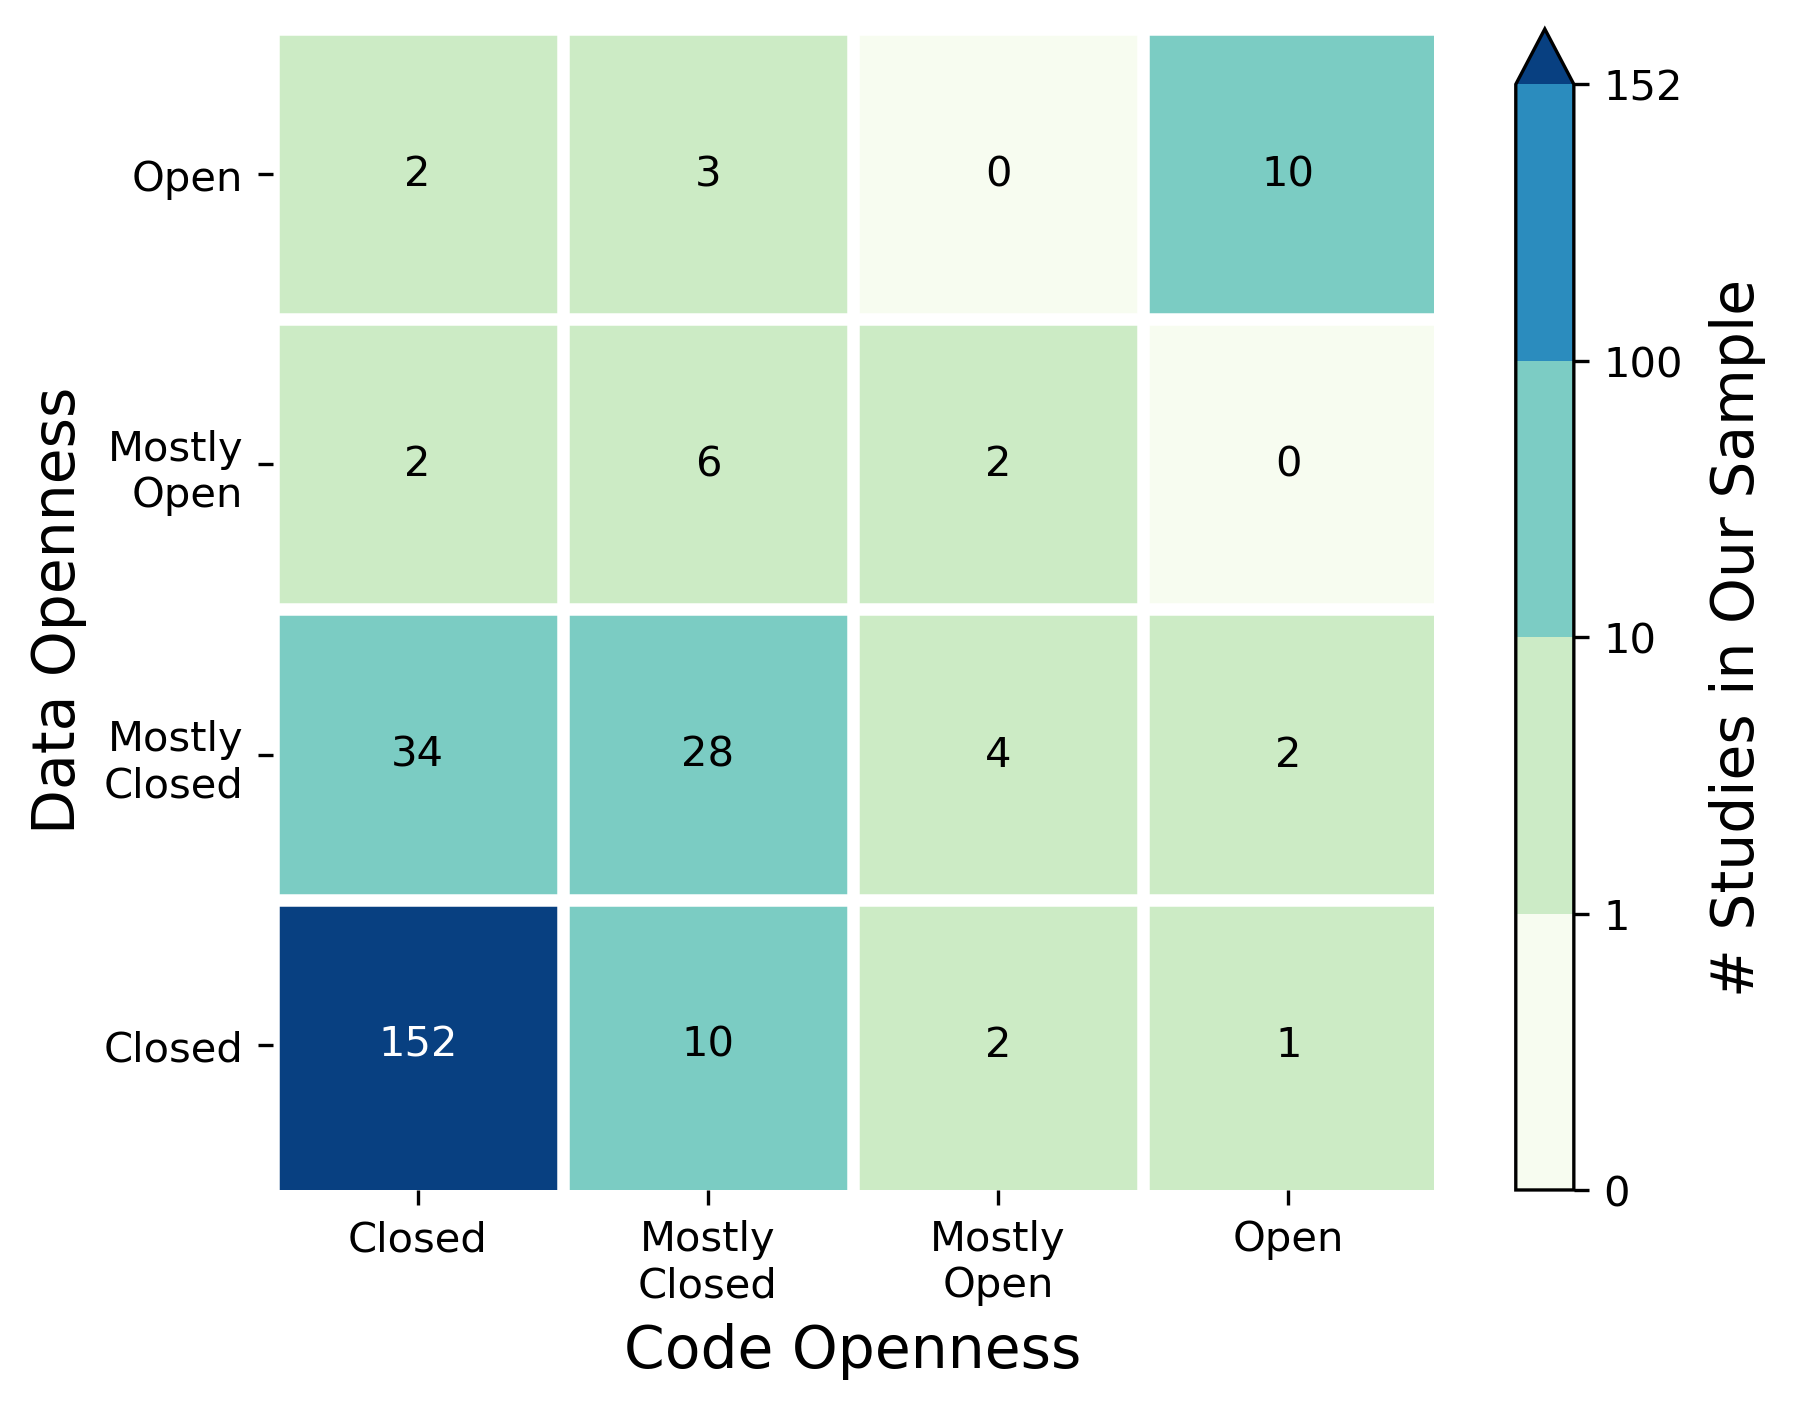

In [79]:
# Modified code from https://matplotlib.org/stable/gallery/
# images_contours_and_fields/image_annotated_heatmap.html
import matplotlib
import matplotlib as mpl
import matplotlib.colors as colors

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=90, va="bottom",
                       labelpad=20, size=14)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1])-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0])-.5, minor=True)
    
    ax.set_xlabel('Code Openness', size=14)
    ax.set_ylabel('Data Openness', size=14)
    
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False, labelsize=12)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, ax = plt.subplots(dpi=300)

names = ['Closed', 'Mostly\nClosed', 'Mostly\nOpen', 'Open']
bounds = np.array([0, 1, 10, 100, 152])
im, cbar = heatmap(hmap_p.values,
                   reversed(names),
                   names,
                   ax=ax,
                   cmap="GnBu",
                   cbarlabel="# Studies in Our Sample",
                   norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='max'))
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
fig.savefig(join(ROOT_DIR, 'fig', 'fig2.png'),
            dpi=600,
            bbox_inches='tight') 